# Clustering on a Quantum Computer

Clustering in the task of grouping a set of points in a space such that those whose coordinates are close together (according to some distance measure) belong to the same cluster. 
In general, clustering is an NP-Hard problem. Most popular clustering algorithms, like Lloyds Algorithm for K-Means, are efficient heuristic algorithms that don't try to find the best cluster, but rather converge quickly to a local optimum. 

A different approach to find good cluster assignment efficiently is by using a quantum computer, which we explore in this notebook. The approach we take is mainly educational, and will not necessarily generate an optimal solution. The aim is to illustrate how a quantum computer can approach a task like this by exploiting two core concepts of quantum computing:
1. Superposition
2. Entanglement
of qubits. What is particularly nice about the clustering problem is that the qubits directly translate to cluster assignment and hence no additional translation step is necessary, as would be the case for example with the traveling salesman problem.
The approach is loosely based on QAOA (Quantum Approximate Optimization Algorithm) as described in [Quantum Algorithms for Fixed Qubit Architectures](https://arxiv.org/pdf/1703.06199.pdf).

In [1]:
import numpy as np
import pandas as pd

from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

from qm_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

## Clustering problem as an Ising model
There is no unique definition of how to define clusters for $N$ coordinates in a $d-$dimensional space. (In this notebook we restrict ourselves without loss of generality two dimensions, although in practice the more interesting clustering problems are those of higher dimensional coordinates.) The definition of "optimal cluster" we use in this notebook is: the clustering assignment that minimizes intra-cluster distances while maximizing inter-cluster distances. For simplicitly we limit ourselves to the case where the data is split into 2 clusters; the general $N$-cluster case can be solved recursively. 

Given this definition of clusters we can easily map this to an Ising model:
$H = \sum_{i,j} J_{i,j} \sigma_{i}^z \sigma_{j}^z$ where the interaction strengths $J_{ij}$ between spins $i$ and $j$ are chosen to be proportional to the Euclidean distance between coordinates $i$ and $j$. The spins $\sigma^z_j$ take values ${-1,1}$ representing the cluster assignment. The $2^N$ eigenstates of the Hamiltonian $H$ correspond to all the $2^N$ possible ways to cluster the $N$ coordinates. The energy is a measure for cluster goodness: the lower the energy, the better the cluster. Finding the eigenvector with lowest energy is an NP-hard problem, like with any other clustering methods.

In [2]:
coordinates = np.array([
    (0.05, 0.0), (0.9, 0.5),
    (1.2, 1.0), (2.7, 3.0),
    (0.2, 0.8), (1.9, 2.9),
    (1.1, 3.0), (2.1, 2.2),
])
coordinates_x, coordinates_y = coordinates.T
N = len(coordinates)

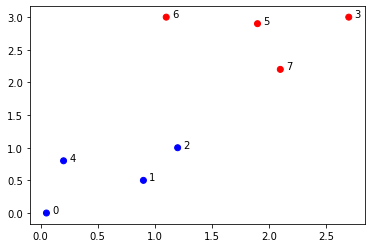

In [3]:
# Binary representation of the cluster. 
# The first bit tells whether the first coordinate belongs to cluster 0 or 1, etc.
cluster = '11101000'
colors = ['b' if int(x) else 'r' for x in cluster]

fig, ax = plt.subplots()
ax.scatter(coordinates_x, coordinates_y,c=colors);
for i in range(0,N):
    ax.annotate(str(i), (coordinates_x[i]+0.05, coordinates_y[i]))

### Classical pre-computation
As a preparation for the quantum algortihm we compute all pairwise distances, which requires only $O(N^2)$ computations. For coordinates that are very close together we want to enhance the probability that they end up in the same cluster. In other words, we want to entangle them in state very similar to $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$. For two particles very far appart we want to entangle them like $\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)$, which has the effect of forcing them to be in opposite clusters.

To achieve this, we map distances to phases in the interval $[-1,1]$ so that we can lineary interpolate between $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$ and $\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)$. A zero phase would leave the qubits un-entangled. 

In [4]:
distances = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        distances[i][j] = np.linalg.norm(coordinates[i]-coordinates[j])
max_distance = np.max(np.abs(distances))

phases = 2.0*(distances/max_distance)-1.0

### Exact solution
When N is sufficiently small, we can solve the problem exactly by computing the eigenvectors of the $(2^N,2^N)$ matrix. 

This allows us to compute metrics which we normally cannot, to give us insights in what is happening under the hood of the quantum algorithm.

In [5]:
H = Hzz(distances)
energies, v = np.linalg.eigh(H)
groundstate = v.T[np.argmin(energies)] #The groundstate(s) (lowest energy state) is the optimal cluster
assert(energies[0]==v.T[0].dot(H).dot(v.T[0]))
groundstate_bin = np.binary_repr(np.argmax(groundstate),width=N)[::-1]
groundstate_bin

'11101000'

In [6]:
info = pd.DataFrame.from_dict({'state':np.argmax(v,axis=0),'energy':energies})
info['eq_state'] = info['state'].apply(lambda x: min(2**N-1-x,x))
info['bits'] = info['state'].apply(lambda x: np.binary_repr(x,N)[::-1])
info.head()

,state,energy,eq_state,bits
0,23,-30.784391,23,11101000
1,232,-30.784391,23,00010111
2,19,-20.983451,19,11001000
3,236,-20.983451,19,00110111
4,104,-18.905612,104,00010110


## Quantum Approximate Optimization Algorithm

### Entanglement sub-circuit
To control the entanglement between two qubits we can use the following unitary gate
$U_{jk}(\phi_x,\phi_z)=e^{-i \phi_x \sigma_{k}} e^{-i \phi_z \sigma_{j}\sigma_{k}}$. 
See below how this translates to quantum gates.

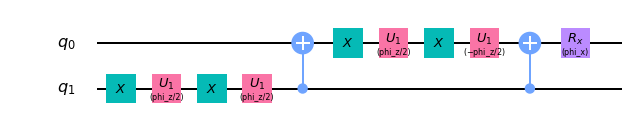

In [7]:
qc_zz_x = QuantumCircuit(2,name='zz_x')

phi_x = Parameter('phi_x')
phi_z = Parameter('phi_z')

qc_zz_x.x(1)
qc_zz_x.u1(phi_z/2,1)
qc_zz_x.x(1)
qc_zz_x.u1(phi_z/2,1)

qc_zz_x.cx(1,0)

qc_zz_x.x(0)
qc_zz_x.u1(phi_z/2,0)
qc_zz_x.x(0)
qc_zz_x.u1(-1*phi_z/2,0)

qc_zz_x.cx(1,0)
qc_zz_x.rx(phi_x,0)

qc_zz_x.draw(output='mpl')

#### Example how to control the entanglement
By changing $\phi_x$, $\phi_z$, we can control the ammount and type of entanglement between two qubits.

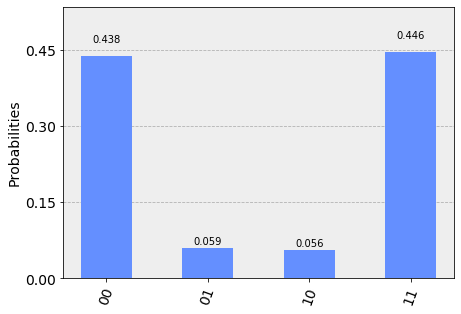

In [8]:
qc_ent = QuantumCircuit(2,2)
qc_ent.h(0)
qc_ent.h(1)
phi_0 = 0.3*np.pi
params_0 = { phi_x : phi_0, phi_z : -2.0*phi_0 }

qc_ent.append(qc_zz_x.bind_parameters(params_0).to_instruction(),[0,1])
qc_ent.measure([0,1],[0,1])

backend_sim = Aer.get_backend('qasm_simulator')
result_ent = execute(qc_ent,backend=backend_sim,shots=4092).result()
counts_ent = result_ent.get_counts(qc_ent)
plot_histogram(counts_ent)

### Complete Quantum Circuit

1. Initialize the system in a uniform superposition
2. Create first layer of entanglement. Based on pre-computed phases.
3. Second layer of entanglement

We could add more layers to supply even more information to the system and get better solutions.

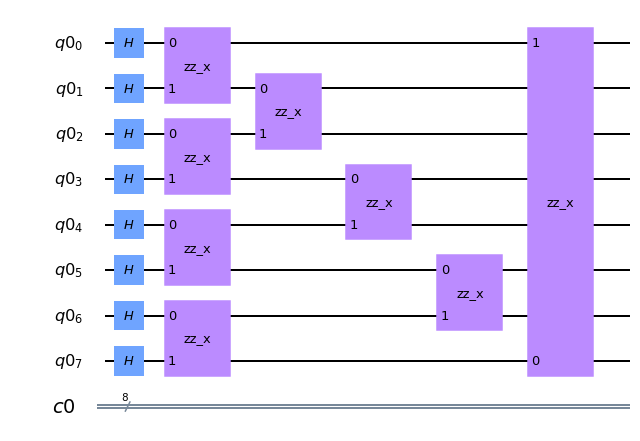

In [9]:
qr = QuantumRegister(N)
cr = ClassicalRegister(N)
qc = QuantumCircuit(qr,cr)

#create uniform superposition
for i in range(0,N):
    qc.h(qr[i])

#first layer of entanglement
for i in range(0,N,2):
    params_1 = {
        phi_x : 0.3*np.pi,
        phi_z : 0.6*np.pi*phases[i][i+1],
    }
    layer1 = qc_zz_x.bind_parameters(params_1)
    qc.append(layer1.to_instruction(),qr[i:i+2])

#second layer of entanglement
for i in range(1,N,2):
    params_2 = {
        phi_x : 0.3*np.pi,
        phi_z : 0.6*np.pi*phases[i%N][(i+1)%N],
    }
    layer2 = qc_zz_x.bind_parameters(params_2)
    qc.append(layer2.to_instruction(),[qr[i%N],qr[(i+1)%N]])

qc.draw(output='mpl')

## A Look Under the Hood
The get a feel for what is going on we use QISKit to compute the exact state vector, i.e. the quantum mechanical state just before we do a measurement. In a real computation on quantum hardware we cannot do this of course, since that would cause the states to collapse.

In [10]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
state = job.result().get_statevector(qc)

In [11]:
amps = []

for e,x in zip(energies,v.T):
    overlap = x.dot(state[::-1])
    amp = (overlap.conj()*overlap).real
    amps.append({'energy':e,'amplitude':amp})
                   
amps_df = pd.DataFrame(amps)            

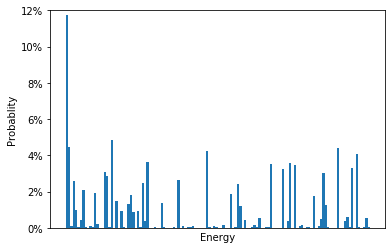

In [12]:
amplitudes = (state.conj()*state).real
info_amp = info.merge(pd.DataFrame.from_dict({'state':list(range(0,2**N)),'amplitude':amplitudes}))
info_amp_agg = info_amp.groupby(['energy'],as_index=False)['amplitude'].sum().sort_values('energy')
plt.bar(list(range(0,2**(N-1))),info_amp_agg['amplitude'],width=1.0)
plt.ylim(0,0.12);
plt.xticks([],[]);
plt.xlabel('Energy');
plt.ylabel('Probablity');
ypos, ylabels = plt.yticks();
plt.yticks(ypos, ["{:.0%}".format(y) for y in ypos]);

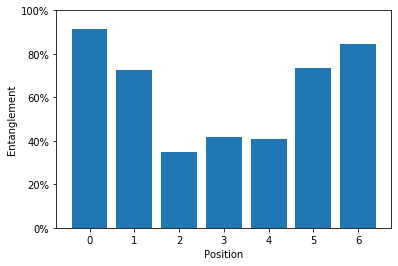

In [13]:
rho = density_matrix(state)
entent = [entanglement_entropy(rho,N-n_left,n_left)/max_entanglement_entropy(min(N-n_left,n_left))
          for n_left in range(1,N)]
plt.bar(list(range(0,N-1)),entent);
plt.ylim(0,1.0);
ypos, ylabels = plt.yticks();
plt.yticks(ypos, ["{:.0%}".format(y) for y in ypos]);
plt.ylabel('Entanglement');
plt.xlabel('Position');

## Simulate an Experiment
Before running it on an actual quantum computer, we run a simulation, by performing "measurement" repeatedly.
To obtain the same type of information as we can get from a quantum computer.

In [14]:
qc_exp = qc.copy()
qc_exp.measure(qr,cr)

In [15]:
backend_sim = Aer.get_backend('qasm_simulator')
result_sim = execute(qc_exp,backend=backend_sim,shots=4092).result()
counts = result_sim.get_counts(qc_exp)
count_df = pd.DataFrame.from_dict({'state':list(counts.keys()),'count':list(counts.values())})
count_df.sort_values('count',ascending=False).head(10)

,state,count
26,11101000,271
55,00010111,242
29,00001111,115
88,01101111,100
83,11110000,98
10,00010011,95
9,00010000,93
121,00010001,92
118,11101100,90
116,00001011,87


## Run it on an actual quantum computer
A QISKIT account is required which can be obtained for free from the [IBM Q Experience](https://quantum-computing.ibm.com/). On the same website you can also see the availability of the various quantum computers.

In [16]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')

In [17]:
job_exp = execute(qc_exp, backend=qcomp,shots=4092)
job_monitor(job_exp)

Job Status: job has successfully run


In [18]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qc_exp)
bit_counts = {'bits':[str(x)for x in list(counts_exp.keys())],'count':list(counts_exp.values())}
count_exp_df = pd.DataFrame.from_dict(bit_counts)

In [19]:
info_amp_exp = info_amp.merge(count_exp_df,how='left').sort_values('count',ascending=False)
info_amp_exp['amp_exp']=info_amp_exp['count']/info_amp_exp['count'].sum()
info_amp_exp.head(10)

,state,energy,eq_state,bits,amplitude,count,amp_exp
188,136,2.050763,119,00010001,0.017890,112,0.027370
240,8,21.964085,8,00010000,0.016575,63,0.015396
17,200,-13.932242,55,00010011,0.000180,63,0.015396
182,148,1.172663,107,00101001,0.016313,61,0.014907
192,9,4.070851,9,10010000,0.017244,58,0.014174
228,144,13.401884,111,00001001,0.021913,55,0.013441
79,73,-4.320881,73,10010010,0.000047,50,0.012219
1,232,-30.784391,23,00010111,0.058768,48,0.011730
250,128,30.690337,127,00000001,0.000294,45,0.010997
7,168,-18.026289,87,00010101,0.012954,44,0.010753


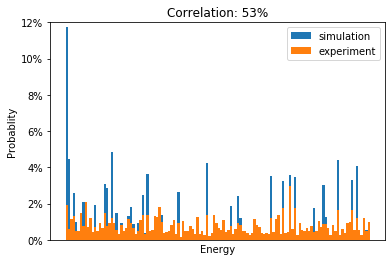

In [24]:
info_amp_exp_agg = info_amp_exp.groupby('eq_state',as_index=False).agg(
    {'energy':'mean','amplitude':'sum','amp_exp':'sum'})
info_amp_exp_agg = info_amp_exp_agg.sort_values('energy')

correlation = np.corrcoef(info_amp_exp_agg['amplitude'],info_amp_exp_agg['amp_exp'])[0][1]

plt.bar(list(range(0,len(info_amp_exp_agg))),info_amp_exp_agg['amplitude'],label='simulation',width=1.0)
plt.bar(list(range(0,len(info_amp_exp_agg))),info_amp_exp_agg['amp_exp'],label='experiment',width=1.0)
plt.legend()
plt.ylim(0,0.12);
plt.xticks([],[]);
plt.xlabel('Energy');
plt.ylabel('Probablity');
ypos, ylabels = plt.yticks();
plt.yticks(ypos, ["{:.0%}".format(y) for y in ypos]);
plt.title('Correlation: {:.0%}'.format(correlation));